# Definition of City Typologies

Jan 06, 2022

---

## Load Data

We load and merge data from different data sources. We use the collected local level economic data to get the main economic sectors of each city, for the economic classification we use the [GHSL](https://ghsl.jrc.ec.europa.eu/) data.

After that, each city is allocated to a specific city type.

In [1]:
from utils import get_data
X, X_num = get_data()
testcol = X.columns
X.drop_duplicates(subset=['city', 'country_code'], inplace=True)

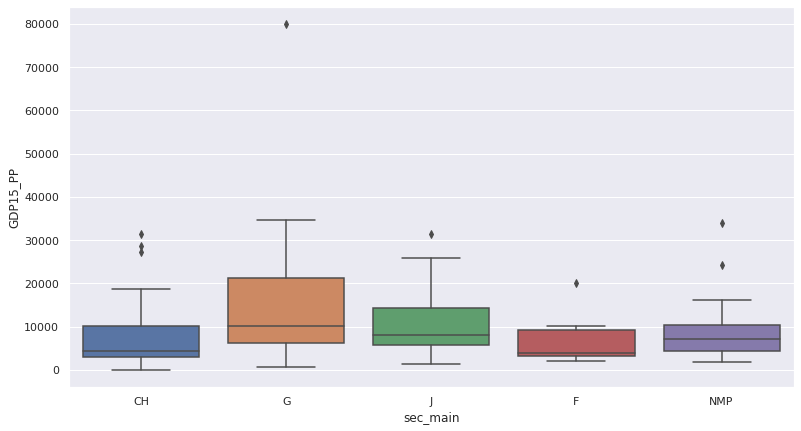

In [2]:
import seaborn as sns

sns.set(rc={"figure.figsize":(13, 7)})
sns.boxplot(x="sec_main", y="GDP15_PP", data=X);

**Figure 1:** Boxplot showing GDP distribution by main economic sector

We can see in figure 1 that there is no clear relationship between the main economic activity of the city and its GDP. 

The cities with the highest GDP are allocated to sector G (Wholesale and retail trade; repair of motor vehicles and motorcycles).

## Clusters (Definition)

We construct the city clusters based on 3 variables:

1. Main economic sector (5)
2. Economic level (3) HIC, UMIC, LMIC
3. Economic diversity (2) low, high

The maximum number of clusters: 5 x 3 x 2 = **30**



In [3]:
import numpy as np
import pandas as pd

table = pd.pivot_table(
    X, values='ce', index=['sec_main',],
    columns=['INCM_CMI'], aggfunc=np.mean)

**Table 1:** Pivot-Table showing the mean circularity index for each city cluster 

In [4]:
table

INCM_CMI       HIC      LMIC      UMIC
sec_main                              
CH        0.059778  0.089241  0.056128
F              NaN  0.126290  0.061873
G         0.060952  0.082329  0.051832
J         0.079589  0.083662  0.028957
NMP       0.092135  0.080861  0.041535

The highest circularity (13%) is attributed to cluster of economic sector F (Construction) for countries of economic classification LMIC (Low-Middle Income Countries). 

The lowest circularity (2%) is attributed to cluster of economic sector J (Information and communication) for countries of economic classification UMIC (Upper-Middle Income Countries).

In [5]:
import pandas as pd

cut = X.hhi_circ_norm.mean()
table = pd.DataFrame(
    columns=['CH','G','J','F','NMP'], 
    index=['HIC','UMIC','LMIC'])
table_num = pd.DataFrame(
    columns=['CH','G','J','F','NMP'],
    index=['HIC','UMIC','LMIC'])
table_circ = pd.DataFrame(
    columns=['CH','G','J','F','NMP'], 
    index=['HIC','UMIC','LMIC'])

for group in X.groupby('sec_main'):
    for EL in ['HIC','UMIC','LMIC']:
        inx = group[1].loc[:, EL]==1
        inx_a = (group[1].loc[:, EL]==1) & (group[1].loc[:, 'hhi_circ_norm']>=cut)
        inx_b = (group[1].loc[:, EL]==1) & (group[1].loc[:, 'hhi_circ_norm']<cut)
        value="({};{})".format(
            group[1].loc[inx_a].shape[0],
            group[1].loc[inx_b].shape[0])
        value_circ="({:0.2%};{:0.2%})".format(
            group[1].loc[inx_a, 'ce'].mean(), 
            group[1].loc[inx_b, 'ce'].mean())
        table.loc[EL,group[0]] = value
        table_num.loc[EL,group[0]] = group[1].loc[inx].shape[0]
        table_circ.loc[EL,group[0]] = value_circ

In [6]:
table_num=table_num.astype(int)
table_num.columns = [
    'Manufacturing, Transportation and Storage', 
    'Wholesale', 'Information and communication', 
    'Construction',
    'Administration, Education'
]

In [7]:
dumm_inc = pd.get_dummies(X.sec_main)
X = X.join(dumm_inc)

dumm_inc = list(dumm_inc.columns)
dumm_inc.append('sec_main')
dumm_inc.append('country_code')

X_new = X.loc[:, dumm_inc].groupby('country_code').sum()
X_new = X_new.T.div(X_new.sum(axis=1))

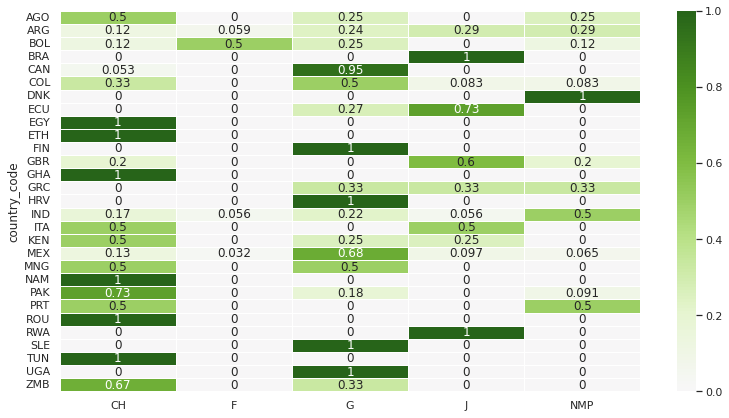

In [8]:
sns.heatmap(
    X_new.T,
    cmap="PiYG", linewidths=0.5, annot=True, center=0.01);

**Figure 2a:** Percentage number of cities per country and main economic sector.

The model for the quantification of CE-jobs (Munoz; Novak et al., 2022) has an Inherited bias attributed from the model's linkage to national level data. National level data has a direct impact on the obtained result. It is difficult to "fix" such bias, as we cannot simply pretend to exchange national context without considering an infinite number of variations on the overall urban system. The use of economic classification as one of the parameters for the construction of the urban typologies is based on a national level classification. It is important, therefor, to understand the variation on economic sectors at a national level. As we can see on figure 2a, a clear distribution at national level trending to favor one main economic sector.

It is difficult to assess these distributions because the number of cities per country has a different effect on the possibilities to achieve a more spread distribution. Nonetheless, we also observe that's not a rule. If we look at the distribution of Canada, a country with many represented cities on this dataset, we see that Canada has a strong allocation of sector G as its main economic sector. 

In [9]:
table_num

Manufacturing, Transportation and Storage  Wholesale  \
HIC                                           4         20   
UMIC                                         12         36   
LMIC                                         26         14   

      Information and communication  Construction  Administration, Education  
HIC                               5             0                          4  
UMIC                             21             2                          9  
LMIC                              3             5                         11

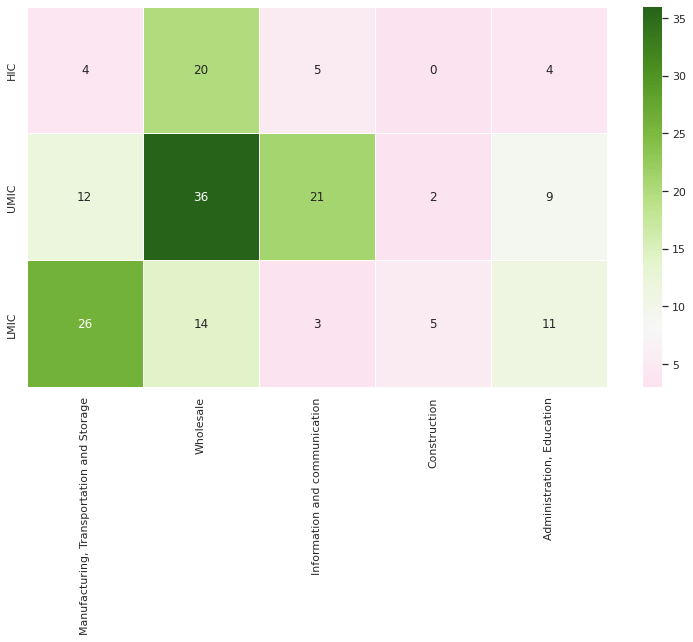

In [10]:
sns.heatmap(table_num, cmap="PiYG", linewidths=0.5, annot=True, center=8, vmin=3);

**Figure 2:** Heatmap showing the number of cities per city-cluster based on income level and main economic activity

Figure 2. Shows the under and over representation of city-clusters. Specially problematic: the low-represented clusters like (Cluster 9: J-LMIC, Cluster 10: FNMP-HIC, Cluster 1: CH-HIC).

Of all city types, only one type has no represents: HIC-F (High Income Country with construction as main economic sector).

**Table 3:** Number of cities by city type, defined based on economic level (row), main economic activity (column) and economic diversity (high;low)

In [11]:
table

CH       G       J      F    NMP
HIC    (0;4)  (1;19)   (0;5)  (0;0)  (0;4)
UMIC   (5;7)  (4;32)  (4;17)  (0;2)  (3;6)
LMIC  (9;17)   (5;9)   (0;3)  (4;1)  (2;9)

**Table 4:** Mean Circularity of cities by city type, defined based on economic level (row), main economic activity (column) and economic diversity (high;low)

In [12]:
table_circ

CH              G              J                F  \
HIC    (nan%;5.98%)  (7.67%;6.01%)   (nan%;7.96%)      (nan%;nan%)   
UMIC  (5.04%;6.03%)  (4.08%;5.32%)  (5.20%;2.35%)     (nan%;6.19%)   
LMIC  (8.81%;8.99%)  (8.83%;7.90%)   (nan%;8.37%)  (12.83%;11.83%)   

                 NMP  
HIC     (nan%;9.21%)  
UMIC   (6.40%;3.03%)  
LMIC  (12.33%;7.14%)

In [13]:
URLS = {
    1: ['https://upload.wikimedia.org/wikipedia/commons/b/b1/Bologna_montage_HD.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/6/6b/Historical_part_of_Porto%2C_Portugal.jpg',],
    2: ['https://upload.wikimedia.org/wikipedia/commons/c/c9/Glaciar_Martial_100_2981.JPG',
        'https://upload.wikimedia.org/wikipedia/commons/4/4b/Montaje_de_la_Ciudad_de_Buenos_Aires.png'],
    3: ['https://upload.wikimedia.org/wikipedia/commons/1/1b/Addis_abeba_meskele_square_%28cropped%29.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/c/c9/Chinggis_Square.jpg'],
    4: ['https://upload.wikimedia.org/wikipedia/commons/6/68/Edmonton_Montage_2020.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/6/65/Toronto_Skyline_Summer_2020.jpg'],
    5: ['https://upload.wikimedia.org/wikipedia/commons/e/e1/Collage_Monterrey.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/f/f5/Metro_de_Medell%C3%ADn%2C_Colombia.jpg'],
    6: ['https://upload.wikimedia.org/wikipedia/commons/9/97/Freetown_arial_view_%283%29.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/3/3a/Collage_Cobija.png'],
    7: ['https://upload.wikimedia.org/wikipedia/commons/5/58/Milan.Proper.Wikipedia.Image.png',
        'https://upload.wikimedia.org/wikipedia/commons/c/c5/Manchester_Montage_2017.jpg'],
    8: ['https://upload.wikimedia.org/wikipedia/commons/b/b9/Recife_-_In%C3%ADcio_da_Avenida_Boa_Viagem.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/e/ed/Banner_Riobamba_Ciudad_Bonita.jpg'],
    9: ['https://upload.wikimedia.org/wikipedia/commons/8/83/Kigali2018Cropped.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/4/42/Nairobi_Montage_A.jpg'],
    10:[],
    11:['https://upload.wikimedia.org/wikipedia/commons/8/8d/BancoNaci%C3%B3n_Trelew2008.JPG',
        'https://upload.wikimedia.org/wikipedia/commons/2/29/CeballosHotelColima.jpg'],
    12:['https://upload.wikimedia.org/wikipedia/commons/0/02/Cadredal_metrpolitana_cochabamba_2019_%281%29.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/1/1b/Jaipur_Montage.png'],
    13:['https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Thessalonica_Montage_L.png/275px-Thessalonica_Montage_L.png',
        'https://upload.wikimedia.org/wikipedia/commons/1/11/Nyhavn-panorama.jpg'],
    14:['https://upload.wikimedia.org/wikipedia/commons/e/eb/Manizales_Montage_L.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/a/a4/La_Paz_Skyline.jpg'],
    15:['https://upload.wikimedia.org/wikipedia/commons/d/df/South-mumbai-2020.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/d/dc/Bab_ay_Sialkot.jpg'],
}

In [14]:
TITLES = {
    "J": "# Information and communication",
    "G": "# Wholesale and retail trade; repair of motor vehicles and motorcycles",
    "F": "# Construction",
    "NMP": "# Administration and education",
    "CH": "# Manufacturing, transport and storage",
}

In [ ]:
e = 0
#text_md = '# Clusters\n\n'
start_table = 5
cols = ['city', 'ce', 'hhi_circ_norm', 'P15_B15', 'GDP15_PP', 'E_EC2E_I15_PP']

for c in table_circ.columns:
    with open('clusters_{}.md'.format(c), 'w') as md_file:
        text_md = "{} -- ({})\n\n".format(TITLES[c], c)
        for r in table_circ.index:
            e += 1
            text_md += "## Cluster - {} ({}-{})\n".format(e, c, r)
            text_md += '; '.join(["{} ({})".format(c[1][0], c[1][1]) 
                                  for c in X.loc[((X.sec_main==c) & (X.INCM_CMI==r)), ['city', 'country_code']].iterrows()])
            text_md += '\n\n'
            if e in URLS.keys():
                for url in URLS[e]:
                    text_md += "[![{0:}]({0:})]({0:})\n".format(url)
                text_md += '\n\n'
            x_tab = X.loc[((X.sec_main==c) & (X.INCM_CMI==r)), cols]
            if x_tab.shape[0] >= 1:
                text_md += '**Table {0:}**: Desription of cluster {1:}'.format(start_table, e)
                start_table += 1
                text_md += '\n\n'
                text_md += x_tab.describe().to_markdown()
                text_md += '\n\n'
                text_md += '**Table {0:}**: Cities of cluster {1:}'.format(start_table, e)
                start_table += 1
                text_md += '\n\n'
                text_md += x_tab.set_index('city').to_markdown()
                text_md += '\n\n'
        md_file.write(text_md)